In [ ]:

# Cell 1 — Installer les dépendances
!pip install transformers datasets torchaudio librosa


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip /content/drive/MyDrive/DailyTalk/dailytalk.zip -d /content/DailyTalk

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /content/DailyTalk/dailytalk/data/775/1_1_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/2_0_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/2_0_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/3_1_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/3_1_d775.wav  
  inflating: /content/DailyTalk/dailytalk/data/775/4_0_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/4_0_d775.wav  
 extracting: /content/DailyTalk/dailytalk/data/775/5_1_d775.txt  
  inflating: /content/DailyTalk/dailytalk/data/775/5_1_d775.wav  
   creating: /content/DailyTalk/dailytalk/data/776/
  inflating: /content/DailyTalk/dailytalk/data/776/0_1_d776.txt  
  inflating: /content/DailyTalk/dailytalk/data/776/0_1_d776.wav  
 extracting: /content/DailyTalk/dailytalk/data/776/10_1_d776.txt  
  inflating: /content/DailyTalk/dailytalk/data/776/10_1_d776.wav  
 extractin

In [2]:

# Cell 2 — Imports & constantes
import os
import torch
import torchaudio
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoProcessor, EncodecModel
from IPython.display import Audio, display

# Paramètres
DEVICE      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAMPLE_RATE = 24000
MAX_LENGTH  = 123840     # ≃5s @ 24kHz
MODEL_DIR   = '/content/checkpoint'

In [4]:

# Cell 3 — Charger processor et modèle
from transformers import AutoProcessor, EncodecModel

processor = AutoProcessor.from_pretrained("/content/checkpoint", local_files_only=True)
model     = EncodecModel.from_pretrained("/content/checkpoint", local_files_only=True).to(DEVICE)
model.eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


EncodecModel(
  (encoder): EncodecEncoder(
    (layers): ModuleList(
      (0): EncodecConv1d(
        (conv): ParametrizedConv1d(
          1, 32, kernel_size=(7,), stride=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
      )
      (1): EncodecResnetBlock(
        (block): ModuleList(
          (0): ELU(alpha=1.0)
          (1): EncodecConv1d(
            (conv): ParametrizedConv1d(
              32, 16, kernel_size=(3,), stride=(1,)
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): _WeightNorm()
                )
              )
            )
          )
          (2): ELU(alpha=1.0)
          (3): EncodecConv1d(
            (conv): ParametrizedConv1d(
              16, 32, kernel_size=(1,), stride=(1,)
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
             

In [23]:
import librosa
import librosa.display
import numpy as np # Ensure numpy is imported for np.max
import matplotlib.pyplot as plt # Ensure matplotlib is imported for plotting


# Cell 4 — Fonction d'inférence et de visualisation
def infer_and_display(path):
    # Chargement audio
    wav, sr = torchaudio.load(path) # Changed to torchaudio.load
    if sr != SAMPLE_RATE:
        wav = torchaudio.transforms.Resample(sr, SAMPLE_RATE)(wav) # Changed to torchaudio.transforms.Resample
    audio = wav.mean(0)
    # Pad/truncate
    if audio.numel() > MAX_LENGTH:
        audio = audio[:MAX_LENGTH]
    else:
        audio = F.pad(audio, (0, MAX_LENGTH - audio.numel()))

    # Prétraitement
    inputs = processor(audio.numpy(), sampling_rate=SAMPLE_RATE,
                       return_tensors='pt', padding='max_length', max_length=MAX_LENGTH)
    input_values = inputs.input_values.to(DEVICE)

    # Remove the explicit channel dimension addition
    # input_values = input_values.unsqueeze(1)

    # Reconstruction
    with torch.no_grad():
        # Pass the tensor to the model
        outputs = model(input_values, return_dict=True)
    recon = outputs.audio_values.cpu().squeeze()
    orig  = audio.cpu()

    # MSE
    mse = F.mse_loss(recon, orig).item()
    print(f'Path: {path} — MSE: {mse:.6f}')

    # Lecture audio
    display(Audio(orig.numpy(), rate=SAMPLE_RATE))
    display(Audio(recon.numpy(), rate=SAMPLE_RATE))

    # Forme d'onde
    plt.figure(figsize=(10,3))
    plt.plot(orig.numpy(), alpha=0.6, label='Original')
    plt.plot(recon.numpy(), alpha=0.6, label='Reconstruction')
    plt.legend(loc='upper right')
    plt.title('Original vs Reconstruction')
    plt.show()

    # Histogramme d'erreur
    error = orig.numpy() - recon.numpy()
    plt.figure(figsize=(5,3))
    plt.hist(error, bins=50, density=True)
    plt.title('Error Distribution')
    plt.xlabel('Error amplitude')
    plt.ylabel('Density')
    plt.show()

    # compute mel-spectrograms
    S_orig = librosa.feature.melspectrogram(y=orig.numpy(), # Specify 'y' as the time series
                                            sr=SAMPLE_RATE,
                                            n_mels=128,
                                            fmax=SAMPLE_RATE//2)
    S_recon = librosa.feature.melspectrogram(y=recon.numpy(), # Specify 'y' as the time series
                                            sr=SAMPLE_RATE,
                                            n_mels=128,
                                            fmax=SAMPLE_RATE//2)
    # convert to log scale (dB)
    log_S_orig  = librosa.power_to_db(S_orig, ref=np.max)
    log_S_recon = librosa.power_to_db(S_recon, ref=np.max)

    plt.figure(figsize=(10, 6))
    plt.subplot(2,1,1)
    librosa.display.specshow(log_S_orig, sr=SAMPLE_RATE,
                            x_axis='time', y_axis='mel')
    plt.title('Original Mel-Spectrogram (dB)')
    plt.colorbar(format='%+2.0f dB')
    plt.subplot(2,1,2)
    librosa.display.specshow(log_S_recon, sr=SAMPLE_RATE,
                            x_axis='time', y_axis='mel')
    plt.title('Reconstructed Mel-Spectrogram (dB)')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show() # Add plt.show() to display the plot

In [24]:

# Cell 5 — Liste des fichiers à tester
sample_paths = [
    '/content/DailyTalk/dailytalk/data/0/0_1_d0.wav',
    '/content/DailyTalk/dailytalk/data/1/0_0_d1.wav',
    "/content/DailyTalk/dailytalk/data/1006/0_0_d1006.wav"
]


Path: /content/DailyTalk/dailytalk/data/0/0_1_d0.wav — MSE: 0.002454


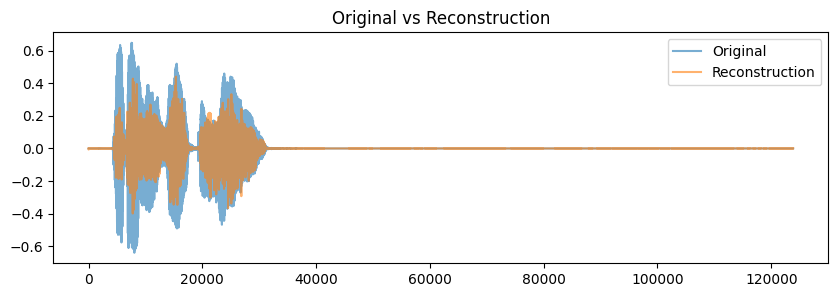

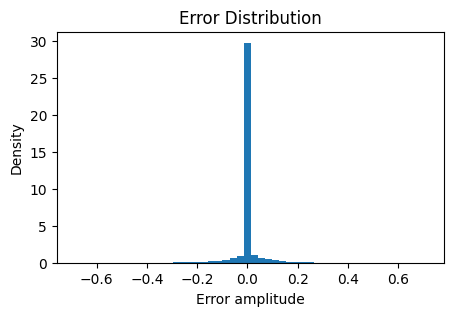

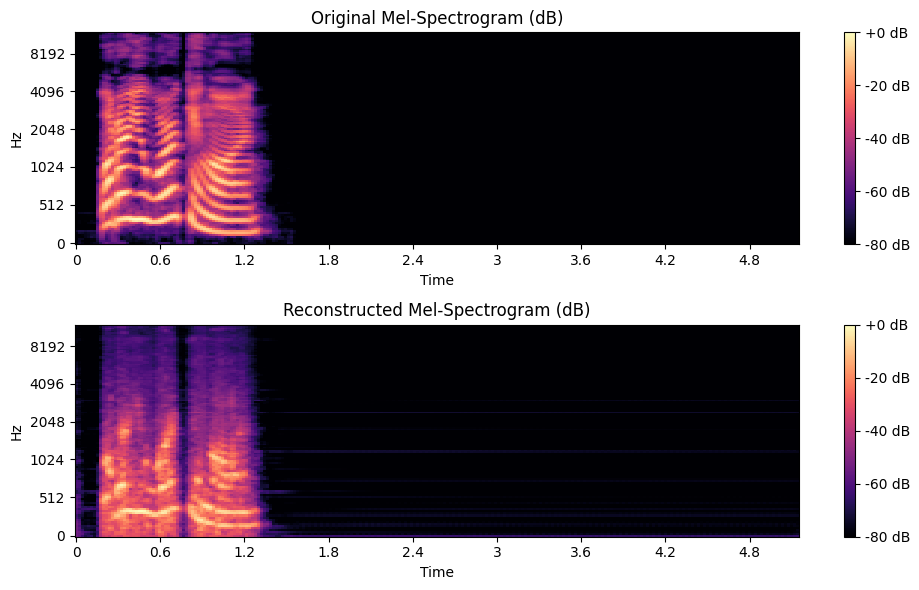


########################################

Path: /content/DailyTalk/dailytalk/data/1/0_0_d1.wav — MSE: 0.001940


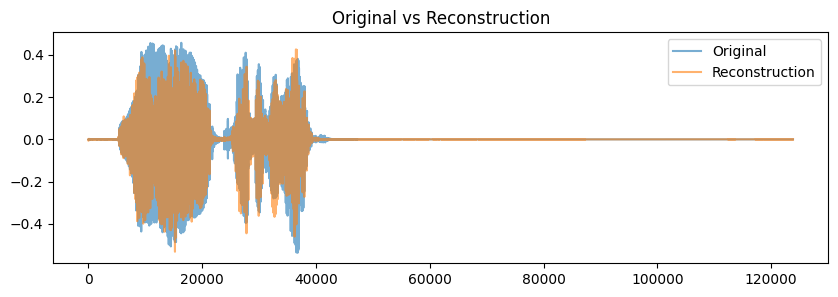

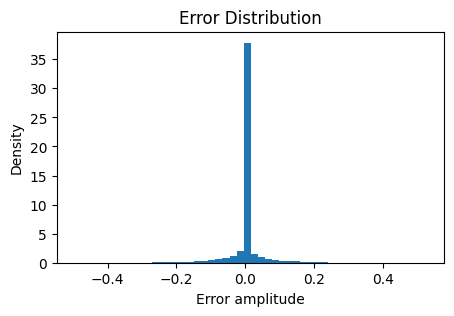

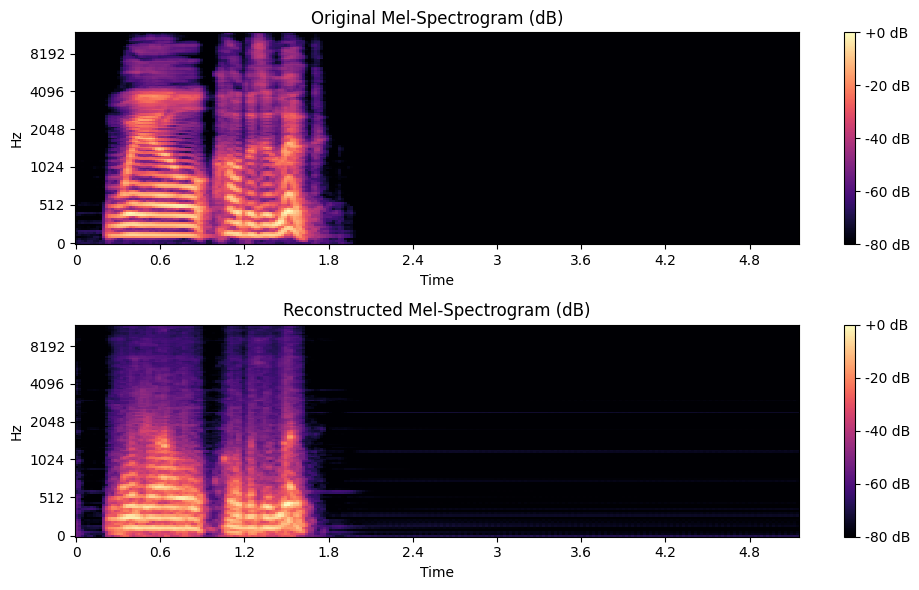


########################################

Path: /content/DailyTalk/dailytalk/data/1006/0_0_d1006.wav — MSE: 0.000775


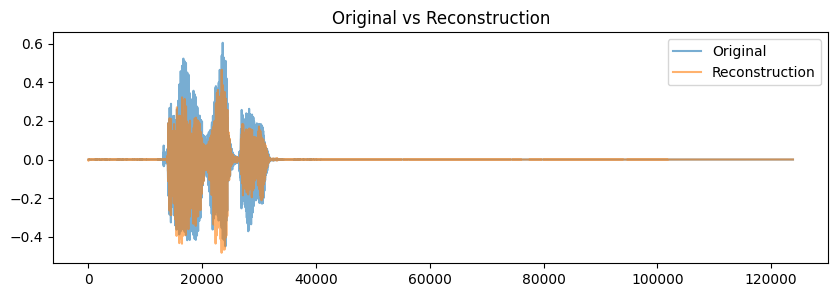

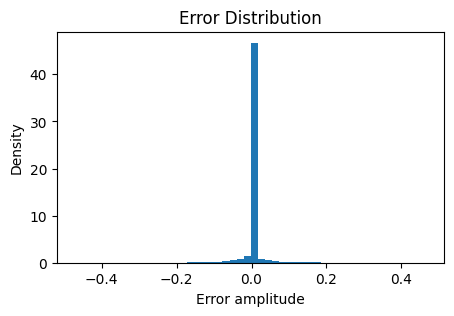

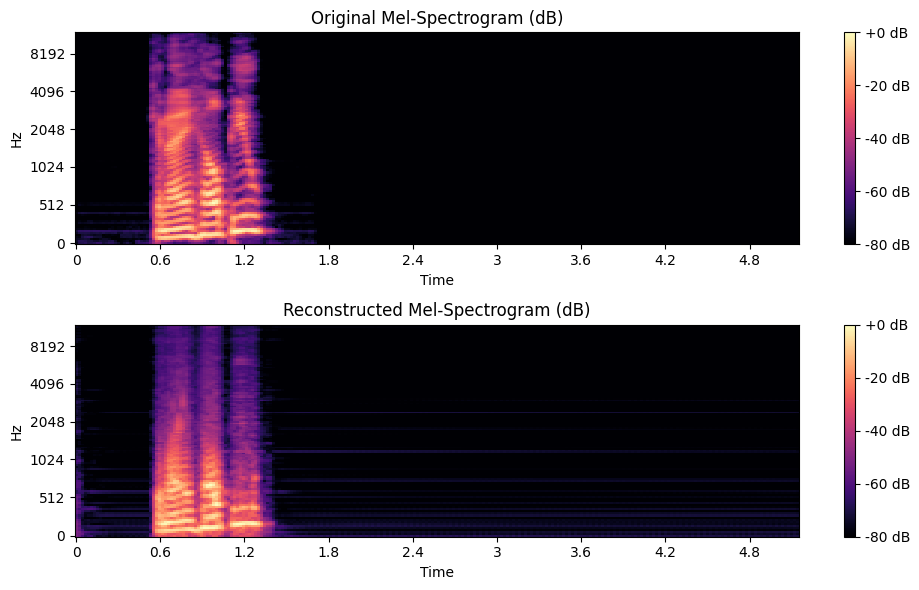


########################################



In [25]:

# Cell 6 — Boucle d'inférence
for path in sample_paths:
    infer_and_display(path)
    print('\n' + '#' * 40 + '\n')

